In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -U tqdm
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Tensors and operations

### Tensors

In [2]:
# matrix
tf.constant([[1., 2., 3.], [4., 5., 6.]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
# scalar
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t.shape

TensorShape([2, 3])

In [5]:
t.dtype

tf.float32

### Indexing

In [6]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [7]:
# ...等于前面所有维度都取:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### Conflicting Types
Tensorflow不会自动执行任何类型转换, 需使用tf.cast()

In [8]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]
cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


In [9]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### Variables
基本不需要使用

In [10]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [11]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 1., 42.,  3.],
       [ 4.,  5.,  6.]], dtype=float32)>

In [12]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 1., 42.,  0.],
       [ 4.,  5.,  1.]], dtype=float32)>

In [13]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  4.,   5., 200.]], dtype=float32)>

In [14]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

## Custom loss function

In [18]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [19]:
# 返回一个损失的张量，而不是返回实例的平均损失
# 这样可以根据要求使用类别权重或样本权重
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

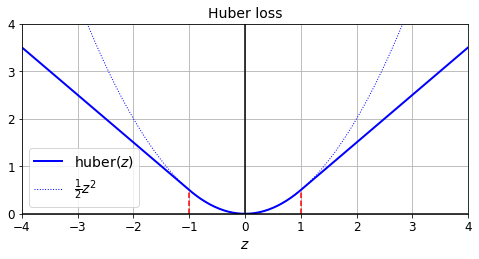

In [20]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [21]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.0443 - mae: 1.4660 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 0s 833us/step - loss: 0.2379 - mae: 0.5407 - val_loss: 0.2382 - val_mae: 0.5281


## Saving/Loading Models with Custom Objects

In [22]:
model.save("my_model_with_a_custom_loss.h5")
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 0s 777us/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


* 当损失函数本身含有可调参数，如阈值时, load_model时也需要设置其参数

In [23]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [24]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.save("my_model_with_a_custom_loss_threshold_2.h5")
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2318 - mae: 0.4979 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 0s 771us/step - loss: 0.2309 - mae: 0.4960 - val_loss: 0.2372 - val_mae: 0.4879


* 或者通过继承`keras.losses.Loss`类，实现其`get_config()`方法

In [25]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [26]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.save("my_model_with_a_custom_loss_class.h5")
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5", # TODO: check PR #25956
                               custom_objects={"HuberLoss": HuberLoss})

model.loss.threshold

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2240 - mae: 0.4892 - val_loss: 0.2327 - val_mae: 0.4751
Epoch 2/2
363/363 [==============================] - 0s 779us/step - loss: 0.2229 - mae: 0.4871 - val_loss: 0.2164 - val_mae: 0.4728


2.0

## Custom Activation Functions, Initializers, Regularizers, and Constraints

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

* 等同于`keras.activations.softplus()`或`tf.nn.softplus()`
* 等同于`keras.initializers.glorot_normal()`
* 等同于`keras.regularizers.l1(0.01)`
* 等同于`keras.contraints.nonneg()`或`tf.nn.relu()`

In [28]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [29]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [30]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.3829 - mae: 1.1635 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 0s 752us/step - loss: 0.6299 - mae: 0.5410 - val_loss: 1.4399 - val_mae: 0.5137


In [31]:
model.save("my_model_with_many_custom_parts.h5")
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

* 同损失函数一样, 当需要保存参数时需继承对应的父类
* Note that you must implement the `call()` method for losses, layers (including activa‐tion functions), and models, or the `__call__()` method for regularizers, initializers, and constraints. 

In [32]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

## Custom Metrics

In [33]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

**Warning**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the **loss** since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is **the sum of the weighted instance losses divided by the _batch size_** (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the **metric** since the start of the epoch is equal to **the sum of weighted instance losses divided by sum of all weights** seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [34]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 605us/step - loss: 1.4306 - huber_fn: 1.4306
Epoch 2/2
363/363 [==============================] - 0s 564us/step - loss: 0.2840 - huber_fn: 0.2840


In [35]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 995us/step - loss: 0.1156 - huber_fn: 0.2338
Epoch 2/2
363/363 [==============================] - 0s 950us/step - loss: 0.1125 - huber_fn: 0.2282


In [36]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11558229476213455, 0.11599889315680392)

### Streaming metrics
* 通常情况：For each batch during training, Keras will compute this metric and keep track of its mean since the beginning of the epoch.
* 当metric值不等于每个batch的metric的均值时(如分类任务中的precision), 需要一个流式指标对象, 每个batch后更新真实的metric.

In [37]:
precision = keras.metrics.Precision()
# batch 1
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [38]:
# batch 2
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [39]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [40]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [41]:
# 重置变量
precision.reset_states()
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [42]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

In [43]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [44]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [45]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 713us/step - loss: 0.6479 - HuberMetric: 1.3055
Epoch 2/2
363/363 [==============================] - 0s 693us/step - loss: 0.1260 - HuberMetric: 0.2491


In [46]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.35711368918418884, 0.3571138122580369)

## Custom Layers

In [47]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [48]:
# Layer with no weights
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

* 构造函数(`__init__()`)接受基本参数(如input_shape, trainable和name), 保存超参数.
* The `build()` method’s role is to create the layer’s variables by calling the `add_weight()` method for each weight. 
* The `call()` method performs the desired operations.
* The `compute_output_shape()` method simply returns the shape of this layer’s outputs.
* The `get_config()` method is just like in the previous custom classes. Note that saving the activation function’s full configuration by calling `keras.activa tions.serialize()`.

In [49]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)# a custom stateful layer (i.e., a layer with weights)
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [50]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 967us/step - loss: 4.1268 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 379us/step - loss: 0.5474


0.5473727583885193

In [51]:
model.save("my_model_with_a_custom_layer.h5")
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [52]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [53]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

If your layer needs to have **a different behavior during training and during testing** (e.g., if it uses Dropout or BatchNormalization layers), then you must add a training argument to the `call()` method and use this argument to decide what to do.

In [54]:
# keras.layers.GaussianNoise
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

## Custom Models

In [55]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

X_new_scaled = X_test_scaled

In [56]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [57]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [58]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 2s 1ms/step - loss: 22.7478
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 1.2735
Epoch 3/5
363/363 [==============================] - 0s 1ms/step - loss: 0.9791
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.5909
Epoch 5/5
162/162 [==============================] - 0s 569us/step - loss: 0.6496


In [59]:
model.save("my_custom_model.ckpt")
model = keras.models.load_model("my_custom_model.ckpt")
history = model.fit(X_train_scaled, y_train, epochs=5)

INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 0.9387
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.6846
Epoch 3/5
363/363 [==============================] - 0s 995us/step - loss: 0.6166
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4438
Epoch 5/5
363/363 [==============================] - 0s 984us/step - loss: 0.5044


Define the model using the sequential API instead

In [60]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

## Losses and Metrics Based on Model Internals

* The constructor creates the DNN with five dense hidden layers and one dense output layer.
* The `build()` method creates an extra dense layer which will be used to recon‐struct the inputs of the model. It must be created here because its number of units must be equal to the number of inputs, and this number is unknown before the `build()` method is called.
* The call() method processes the inputs through all five hidden layers, then passes the result through the reconstruction layer, which produces the recon‐struction.
* Then the call() method computes the reconstruction loss (the mean squared difference between the reconstruction and the inputs), and adds it to the model’s list of losses using the add_loss() method.11 Notice that we scale down the reconstruction loss by multiplying it by 0.05 (this is a hyperparameter you can tune). This ensures that the reconstruction loss does not dominate the main loss.
* Finally, the `call()` method passes the output of the hidden layers to the output layer and returns its output.

In [61]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [62]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [63]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2


InaccessibleTensorError: in user code:

    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:229 __call__
        reg_loss = math_ops.add_n(regularization_losses)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3572 add_n
        return gen_math_ops.add_n(inputs, name=name)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py:419 add_n
        "AddN", inputs=inputs, name=name)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/framework/func_graph.py:588 _create_op_internal
        inp = self.capture(inp)
    /app/anaconda3/envs/studio/lib/python3.6/site-packages/tensorflow/python/framework/func_graph.py:638 capture
        % (tensor, tensor.graph, self))

    InaccessibleTensorError: The tensor 'Tensor("mul:0", shape=(), dtype=float32)' cannot be accessed here: it is defined in another function or code block. Use return values, explicit Python locals or TensorFlow collections to access it. Defined in: FuncGraph(name=build_graph, id=140439413508584); accessed from: FuncGraph(name=train_function, id=140439413552856).
    


## Computing Gradients with Autodiff

In [64]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [65]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In some cases you may want to stop gradients from backpropagating through some part of your neural network. 

To do this, you must use the `tf.stop_gradient()` function returns its inputs during the forward pass (like `tf.identity()`), but it does not let gradients through during backpropagation (it acts like a constant)

In [66]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

## Custom Training Loops

In [67]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [68]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [69]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [70]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [71]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


In [72]:
# A fancier version with a progress bar:

def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [73]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [74]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [75]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [76]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.6440 - mean_absolute_error: 0.5222


In [77]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

To run this cell, please install tqdm, ipywidgets and restart Jupyter


## TensorFlow Functions

Most of the time, converting a Python function that performs TensorFlow operations into a TF Function is trivial: decorate it with `@tf.function` or let Keras take care of it for you. However, there are a few rules to respect:

* If you call any external library, including NumPy or even the standard library, this call will run only during tracing; it will not be part of the graph. Indeed, a TensorFlow graph can only include TensorFlow constructs (tensors, operations, variables, datasets, and so on). So, make sure you use `tf.reduce_sum()` instead of `np.sum()`, `tf.sort()` instead of the built-in `sorted()` function, and so on (unless you really want the code to run only during tracing). This has a few additional implications:
    * If you define a TF Function f(x) that just returns np.random.rand(), a random number will only be generated when the function is traced, so f(tf.constant(2.)) and f(tf.constant(3.)) will return the same random number, but f(tf.constant([2., 3.])) will return a different one. If you replace np.random.rand() with tf.random.uniform([]), then a new random number will be generated upon every call, since the operation will be part of the graph.
    * If your non-TensorFlow code has side effects (such as logging something or updating a Python counter), then you should not expect those side effects to occur every time you call the TF Function, as they will only occur when the function is traced.
    * You can wrap arbitrary Python code in a `tf.py_function()` operation, but doing so will hinder performance, as TensorFlow will not be able to do any graph optimization on this code. It will also reduce portability, as the graph will only run on platforms where Python is available (and where the right libraries are installed).
* You can call other Python functions or TF Functions, but they should follow the same rules, as TensorFlow will capture their operations in the computation graph. Note that these other functions do not need to be decorated with `@tf.function`.
* If the function creates a TensorFlow variable (or any other stateful TensorFlow object, such as a dataset or a queue), it must do so upon the very first call, and only then, or else you will get an exception. It is usually preferable to create variables outside of the TF Function (e.g., in the `build()` method of a custom layer). If you want to assign a new value to the variable, make sure you call its assign() method, instead of using the = operator.
* The source code of your Python function should be available to TensorFlow. If the source code is unavailable (for example, if you define your function in the Python shell, which does not give access to the source code, or if you deploy only the compiled *.pyc Python files to production), then the graph generation process will fail or have limited functionality.
* TensorFlow will only capture for loops that iterate over a tensor or a dataset. So make sure you use for i in `tf.range(x)` rather than `for i in range(x)`, or else the loop will not be captured in the graph. Instead, it will run during tracing. (This may be what you want if the for loop is meant to build the graph, for example to create each layer in a neural network.)
* As always, for performance reasons, you should prefer a vectorized implementation whenever you can, rather than using loops.